# EfficientNetB0V2 with SMOTE for Imbalanced data with final dataset

# Import Libraries

In [1]:
from clearml import Task
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import random
import shutil
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.utils import shuffle
import cv2
from skimage.transform import resize
import seaborn as sns

In [2]:
task = Task.init(project_name='Architecture Style Classification', task_name='Using SMOTE for balancing')

ClearML Task: created new task id=9f42a5bd4cdf448cb20971039ca5e5a6
2024-04-13 17:09:35,594 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fb01ac3f8ec0442db15dd95b35c1dc10/experiments/9f42a5bd4cdf448cb20971039ca5e5a6/output/log


# Data Extraction

In [3]:
dataset_path = "D:/University/FinalDataset"
def get_image_paths_and_labels(directory_path):
    data = []
    for root, dirs, files in os.walk(directory_path):
        for label in dirs:
            label_path = os.path.join(root, label)
            for image_path in glob(os.path.join(label_path, "*")):  
                if os.path.isfile(image_path):
                    label_hierarchy = os.path.relpath(label_path, directory_path).split(os.path.sep)
                    label_string = ", ".join(label_hierarchy)
                    data.append((image_path, label_string))

    return data

In [4]:
images_with_labels = get_image_paths_and_labels(dataset_path)
data = pd.DataFrame(images_with_labels, columns=['image_name', 'label'])
data

,image_name,label
0,D:/University/FinalDataset\Novelty architecture\010434.jpg,Novelty architecture
1,D:/University/FinalDataset\Novelty architecture\010435.jpg,Novelty architecture
2,D:/University/FinalDataset\Novelty architecture\010436.jpg,Novelty architecture
3,D:/University/FinalDataset\Novelty architecture\010437.jpg,Novelty architecture
4,D:/University/FinalDataset\Novelty architecture\010438.jpg,Novelty architecture
...,...,...
18099,D:/University/FinalDataset\Revivalism\Tudor Revival architecture\965_800px-Schuyler%2C_Nebraska_Carnegie_library_from_NE_2.JPG,"Revivalism, Tudor Revival architecture"
18100,D:/University/FinalDataset\Revivalism\Tudor Revival architecture\966_800px-Schuyler%2C_Nebraska_Carnegie_library_from_E.JPG,"Revivalism, Tudor Revival architecture"
18101,D:/University/FinalDataset\Revivalism\Tudor Revival architecture\968_800px-Klehm_House_3.jpg,"Revivalism, Tudor Revival architecture"
18102,D:/University/FinalDataset\Revivalism\Tudor Revival architecture\969_800px-Klehm_House_4.jpg,"Revivalism, Tudor Revival architecture"


# Data Exploration

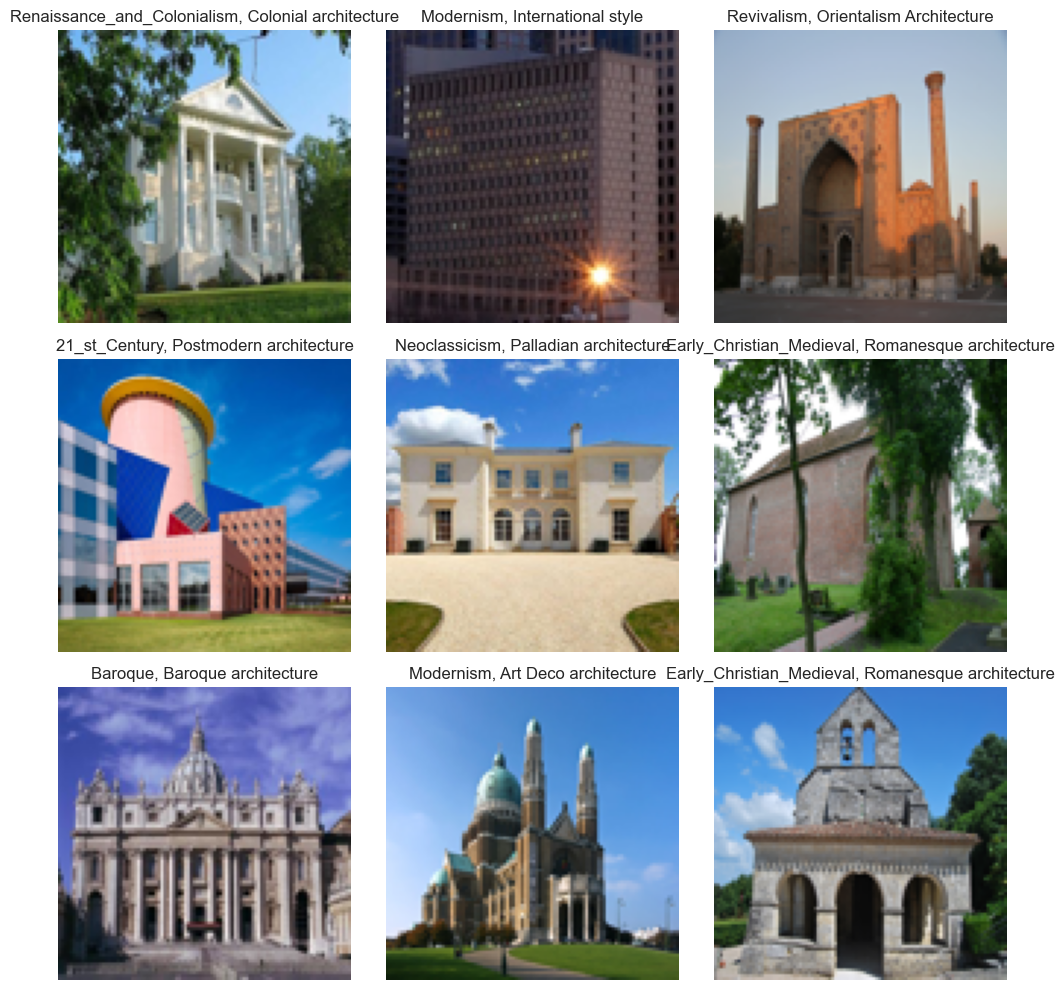

In [5]:
classes = [subfolder for subfolder in os.listdir(dataset_path) if
           os.path.isdir(os.path.join(dataset_path, subfolder))]
plt.figure(figsize=(10, 10))
data_to_show = data.sample(frac=1)[:9]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    img = Image.open(data_to_show.iloc[i, 0])  
    img_resized = img.resize((100, 100))
    plt.imshow(img_resized)
    plt.title(data_to_show.iloc[i, 1])  
    plt.axis("off")
plt.tight_layout()
plt.show()

# Data Split

In [6]:
train_dataset, test_dataset = train_test_split(data,
                                               stratify=data['label'],
                                               test_size=0.1,
                                                random_state=42)
print(f"Train : Test - {train_dataset.shape} : {test_dataset.shape}")

Train : Test - (16293, 2) : (1811, 2)


In [7]:
train_dir = 'D:/University/FinalDatasetSplited/train'
test_dir = 'D:/University/FinalDatasetSplited/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [9]:
for index, row in train_dataset.iterrows():
    image_path = row['image_name']
    label = row['label']
    label_folder = os.path.join(train_dir, label)
    os.makedirs(label_folder, exist_ok=True)
    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(label_folder, image_name))

In [11]:
for index, row in test_dataset.iterrows():
    image_path = row['image_name']
    label = row['label']
    label_folder = os.path.join(test_dir, label)
    os.makedirs(label_folder, exist_ok=True)
    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(label_folder, image_name))

In [6]:
train_dataset, temp_dataset = train_test_split(data,
                                               stratify=data['label'],
                                               test_size=0.2,
                                               random_state=42)
test_dataset, validation_dataset = train_test_split(temp_dataset,
                                                    stratify=temp_dataset['label'],
                                                    test_size=0.5,
                                                    random_state=42)
print(f"Train : Validation : Test - {train_dataset.shape} : {validation_dataset.shape} : {test_dataset.shape}")

Train : Validation : Test - (14483, 2) : (1811, 2) : (1810, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


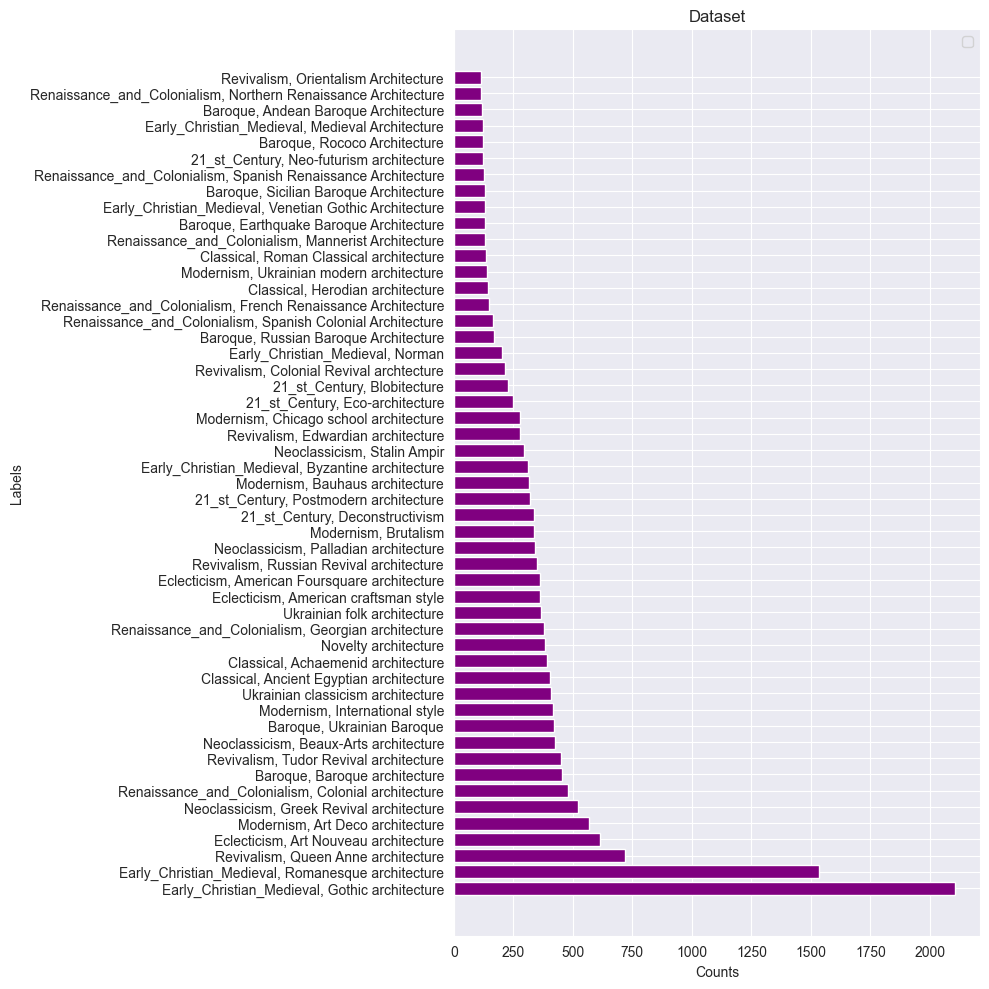

In [7]:
general_dataset_labels = data['label'].value_counts()
unique_labels = general_dataset_labels.index.tolist()
unique_labels.sort(key=lambda label: general_dataset_labels[label], reverse=True)

plt.figure(figsize=(10, 10))
plt.barh(range(len(unique_labels)), [general_dataset_labels.get(label, 0) for label in unique_labels], color='purple')
plt.title('Dataset')

plt.xlabel('Counts')
plt.ylabel('Labels')
plt.yticks(range(len(unique_labels)), unique_labels)
plt.tight_layout()
plt.show()

# Using SMOTE for Data Imbalance problem

In [8]:

print("Class distribution before SMOTE:")
print(train_dataset['label'].value_counts())
X = train_dataset.drop(columns=['label'])
y = train_dataset['label']

def load_and_preprocess_image(image_path, target_size=(224, 224), mode='RGB'):
    try:

        img = Image.open(image_path)

        if img.mode != 'RGB':
            img = img.convert('RGB')
 
        img_resized = img.resize(target_size)
        return np.array(img_resized)  
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

X_train = []
for image_path in train_dataset['image_name']:
    image_array = load_and_preprocess_image(image_path)
    if image_array is not None:
        X_train.append(image_array)



Class distribution before SMOTE:
label
Early_Christian_Medieval, Gothic architecture                     1684
Early_Christian_Medieval, Romanesque architecture                 1225
Revivalism, Queen Anne architecture                                576
Eclecticism, Art Nouveau architecture                              492
Modernism, Art Deco architecture                                   453
Neoclassicism, Greek Revival architecture                          418
Renaissance_and_Colonialism, Colonial architecture                 385
Baroque, Baroque architecture                                      365
Revivalism, Tudor Revival architecture                             361
Neoclassicism, Beaux-Arts architecture                             339
Baroque, Ukrainian Baroque                                         338
Modernism, International style                                     333
Ukrainian classicism architecture                                  327
Classical, Ancient Egyptian architectu

In [10]:
# smote = SMOTEENN(random_state=42)
# 
# # X_train = np.array(X_train)
# # X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, np.prod(X_train.shape[1:])), y_train)
# # 
# # # Reshape the flattened images back to the original shape
# # X_train_resampled = X_train_resampled.reshape(-1, *X_train.shape[1:])
# # 
# # # Shuffle the resampled training data
# # X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
# # train_dataset_resampled = pd.DataFrame({'image_name': X_train_resampled, 'label': y_train_resampled})
# # train_dataset_resampled.head()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# image_shapes = [image.shape for image in X_train[:5]]
# print("Image shapes:", image_shapes)

# Convert list of image arrays to a NumPy array
X_train1 = np.array(X_train)
print("Image shapes:", X_train1.shape)
X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1] * X_train1.shape[2] * X_train1.shape[3])
print("Image shapes:", X_train1.shape)
# Apply SMOTE
smote = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train1, y)
# Reshape X_train to be a 4D array (num_samples, height, width, channels)
# X_train1 = X_train1.reshape(-1, *X_train1.shape[1:])
# 
# # Apply SMOTE
# smote = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Image shapes: (14483, 224, 224, 3)
Image shapes: (14483, 150528)


MemoryError: Unable to allocate 96.3 GiB for an array with shape (85884, 150528) and data type float64

In [11]:
X_train_resampled.shape


NameError: name 'X_train_resampled' is not defined

# Image Data Generators

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3

abs_file_names = []

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   shear_range=0.1,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.4,1.5],
                                   )

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_dataframe(
    train_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
)

validation_generator = test_datagen.flow_from_dataframe(
    validation_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_generator = test_datagen.flow_from_dataframe(
    test_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14468 validated image filenames belonging to 51 classes.
Found 1809 validated image filenames belonging to 51 classes.
Found 1809 validated image filenames belonging to 51 classes.


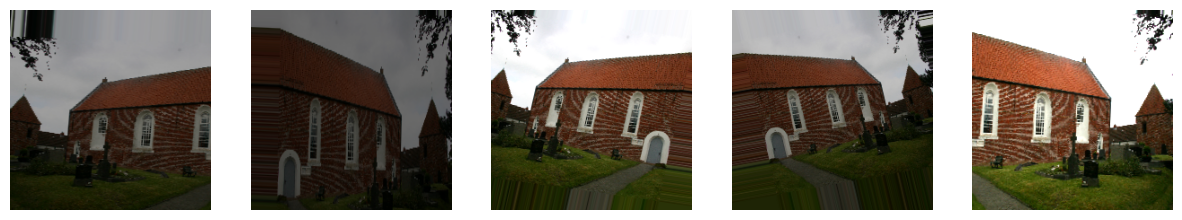

In [9]:
augmented_images = [train_generator[0][0][0] for _ in range(5)]  
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, image in enumerate(augmented_images):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()

# Creating Model

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [11]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [17]:
def arc_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                        include_top=False,
                                                        weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(51, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [18]:
arch_model = arc_model(IMG_SIZE)
# Print a summary for each layer
print(arch_model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 51)             │        13,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,949,891 (34.14 MB)

 Trainable params: 3,030,579 (11.56 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None


In [23]:
arch_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.F1Score, "precision"])
Image.MAX_IMAGE_PIXELS = None

In [24]:
res = arch_model.fit(
    train_generator,
    # steps_per_epoch=176, # 22,564 images = batch_size * steps
    epochs=10,
    verbose=1,
    validation_data = validation_generator, # 2,513 images = batch_size * steps
    callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/10
212/453 ━━━━━━━━━━━━━━━━━━━━ 7:45 2s/step - accuracy: 0.1088 - f1_score: 0.0076 - loss: 3.7517 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1095 - f1_score: 0.0072 - loss: 3.7342 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 975s 2s/step - accuracy: 0.1095 - f1_score: 0.0072 - loss: 3.7341 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6794 - val_precision: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
271/453 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.1152 - f1_score: 0.0050 - loss: 3.6854 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1159 - f1_score: 0.0051 - loss: 3.6824 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 791s 2s/step - accuracy: 0.1159 - f1_score: 0.0051 - loss: 3.6823 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6753 - val_precision: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
167/453 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.1263 - f1_score: 0.0063 - loss: 3.6572 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1206 - f1_score: 0.0056 - loss: 3.6647 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 




Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
453/453 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.1205 - f1_score: 0.0056 - loss: 3.6647 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6482 - val_precision: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
259/453 ━━━━━━━━━━━━━━━━━━━━ 4:58 2s/step - accuracy: 0.1250 - f1_score: 0.0046 - loss: 3.6399 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1218 - f1_score: 0.0045 - loss: 3.6473 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - accuracy: 0.1218 - f1_score: 0.0045 - loss: 3.6473 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6480 - val_precision: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 5/10
307/453 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.1199 - f1_score: 0.0045 - loss: 3.6457 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1190 - f1_score: 0.0044 - loss: 3.6484 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 




Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
453/453 ━━━━━━━━━━━━━━━━━━━━ 784s 2s/step - accuracy: 0.1190 - f1_score: 0.0044 - loss: 3.6484 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6484 - val_precision: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 6/10
200/453 ━━━━━━━━━━━━━━━━━━━━ 6:20 2s/step - accuracy: 0.1173 - f1_score: 0.0041 - loss: 3.6695 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1171 - f1_score: 0.0041 - loss: 3.6622 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.1171 - f1_score: 0.0041 - loss: 3.6622 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6463 - val_precision: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 7/10
437/453 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1190 - f1_score: 0.0042 - loss: 3.6572 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1189 - f1_score: 0.0042 - loss: 3.6572 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 




Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
453/453 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - accuracy: 0.1189 - f1_score: 0.0042 - loss: 3.6572 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6461 - val_precision: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 8/10
364/453 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.1161 - f1_score: 0.0041 - loss: 3.6693 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1163 - f1_score: 0.0041 - loss: 3.6658 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 787s 2s/step - accuracy: 0.1163 - f1_score: 0.0041 - loss: 3.6658 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6465 - val_precision: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 9/10
250/453 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.1130 - f1_score: 0.0040 - loss: 3.6543 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1134 - f1_score: 0.0040 - loss: 3.6574 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 




Epoch 9: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
453/453 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.1134 - f1_score: 0.0040 - loss: 3.6574 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6462 - val_precision: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 10/10
108/453 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.1115 - f1_score: 0.0039 - loss: 3.6590 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1155 - f1_score: 0.0041 - loss: 3.6599 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



453/453 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.1155 - f1_score: 0.0041 - loss: 3.6599 - precision: 0.0000e+00 - val_accuracy: 0.1161 - val_f1_score: 0.0041 - val_loss: 3.6463 - val_precision: 0.0000e+00 - learning_rate: 6.2500e-05


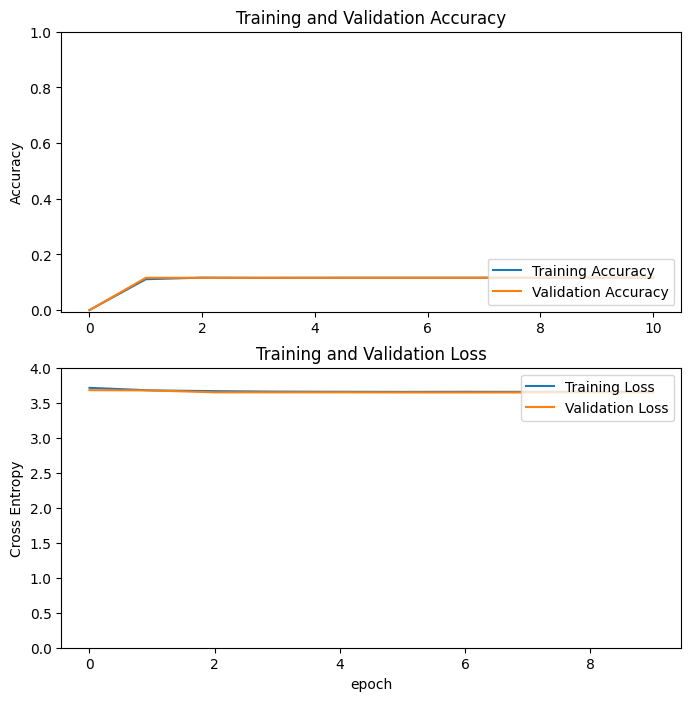

In [25]:
    # validation_steps=20)
acc = [0.] + res.history['accuracy']
val_acc = [0.] + res.history['val_accuracy']

loss = res.history['loss']
val_loss = res.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
loss, accuracy = arch_model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=0)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: image file is truncated (11 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 250, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 244, in generator_fn
    yield self.py_dataset[i]

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\utils\image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\Image.py", line 2185, in resize
    self.load()

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\ImageFile.py", line 288, in load
    raise OSError(msg)

OSError: image file is truncated (11 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_68569]

In [28]:
prediction = arch_model.predict(test_generator, batch_size=BATCH_SIZE, verbose=0)
pr = np.argmax(prediction, axis=1)
print(classification_report(test_generator.labels, pr, target_names=unique_labels))

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OSError: image file is truncated (11 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 250, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 244, in generator_fn
    yield self.py_dataset[i]

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\utils\image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\Image.py", line 2185, in resize
    self.load()

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\ImageFile.py", line 288, in load
    raise OSError(msg)

OSError: image file is truncated (11 bytes not processed)


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

In [29]:
# conf_matrix = confusion_matrix(test_generator.labels, pr)
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

In [31]:
for epoch, history in enumerate(res.history['loss']):
    task.get_logger().report_scalar("training", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['accuracy']):
    task.get_logger().report_scalar("training", "accuracy", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_loss']):
    task.get_logger().report_scalar("validation", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_accuracy']):
    task.get_logger().report_scalar("validation", "accuracy", history, iteration=epoch)


In [32]:
arch_model.save("imbalanced.h5")
task.upload_artifact("imbalanced.h5", name="imbalanced")

TypeError: F1Score.get_config() missing 1 required positional argument: 'self'